In [1]:
import os

import ray
import yaml
from ray.rllib.agents.ppo import PPOTrainer

from foundation.utils import plotting
from foundation.utils.rllib_env_wrapper import RLlibEnvWrapper


def generate_rollout_from_current_trainer_policy(trainer, env_obj, num_dense_logs=1):
    dense_logs = {}
    for idx in range(num_dense_logs):
        # Set initial states
        agent_states = {}
        for agent_idx in range(env_obj.env.n_agents):
            agent_states[str(agent_idx)] = trainer.get_policy("a").get_initial_state()
        planner_states = trainer.get_policy("p").get_initial_state()

        # Play out the episode
        obs = env_obj.reset(force_dense_logging=True)
        for t in range(env_obj.env.episode_length):
            actions = {}
            for agent_idx in range(env_obj.env.n_agents):
                # Use the trainer object directly to sample actions for each agent
                actions[str(agent_idx)] = trainer.compute_action(
                    obs[str(agent_idx)],
                    agent_states[str(agent_idx)],
                    policy_id="a",
                    full_fetch=False,
                )

            # Action sampling for the planner
            actions["p"] = trainer.compute_action(
                obs["p"], planner_states, policy_id="p", full_fetch=False
            )

            actions = {k: v[0] if k != "p" else [v[0]] for k, v in actions.items()}

            obs, rew, done, info = env_obj.step(actions)
            if done["__all__"]:
                break
        dense_logs[idx] = env_obj.env.dense_log
    return dense_logs


ray.init(webui_host="127.0.0.1")

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

{'node_ip_address': '172.18.49.187',
 'redis_address': '172.18.49.187:23085',
 'object_store_address': '/tmp/ray/session_2023-08-17_17-32-42_682041_813531/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2023-08-17_17-32-42_682041_813531/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2023-08-17_17-32-42_682041_813531'}

In [2]:
config_path = os.path.join("./experiments", "config.yaml")

with open(config_path, "r") as f:
    run_configuration = yaml.safe_load(f)

trainer_config = run_configuration.get("trainer")
env_config = {
    "env_config_dict": run_configuration.get("env"),
    "num_envs_per_worker": trainer_config.get("num_envs_per_worker"),
}
dummy_env = RLlibEnvWrapper(env_config, verbose=True)

agent_policy_tuple = (
    None,
    dummy_env.observation_space,
    dummy_env.action_space,
    run_configuration.get("agent_policy"),
)
planner_policy_tuple = (
    None,
    dummy_env.observation_space_pl,
    dummy_env.action_space_pl,
    run_configuration.get("planner_policy"),
)

policies = {"a": agent_policy_tuple, "p": planner_policy_tuple}


def policy_mapping_fun(i):
    return "a" if str(i).isdigit() else "p"


if run_configuration["general"]["train_planner"]:
    policies_to_train = ["a", "p"]
else:
    policies_to_train = ["a"]

trainer_config.update(
    {
        "env_config": env_config,
        "seed": 2014,
        "multiagent": {
            "policies": policies,
            "policies_to_train": policies_to_train,
            "policy_mapping_fn": policy_mapping_fun,
        },
        "metrics_smoothing_episodes": trainer_config.get("num_workers")
        * trainer_config.get("num_envs_per_worker"),
    }
)

trainer = PPOTrainer(env=RLlibEnvWrapper, config=trainer_config)

2023-08-17 17:32:49,813	INFO trainer.py:428 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution


[EnvWrapper] Spaces
[EnvWrapper] Obs (a)   
action_mask    : (31,)
flat           : (69,)
time           : (1,)
world-idx_map  : (1, 11, 11)
world-map      : (7, 11, 11)


[EnvWrapper] Obs (p)   
action_mask    : (1,)
flat           : (39,)
p0             : (4,)
p1             : (4,)
p2             : (4,)
p3             : (4,)
p4             : (4,)
p5             : (4,)
p6             : (4,)
p7             : (4,)
p8             : (4,)
p9             : (4,)
time           : (1,)


[EnvWrapper] Action (a) Discrete(31)
[EnvWrapper] Action (p) MultiDiscrete([1])


2023-08-17 17:32:50,702	ERROR logger.py:193 -- pip install 'ray[tune]' to see TensorBoard files.
2023-08-17 17:32:50,704	WARNING logger.py:308 -- Could not instantiate TBXLogger: cannot import name 'builder' from 'google.protobuf.internal' (/opt/conda/lib/python3.7/site-packages/google/protobuf/internal/__init__.py).
2023-08-17 17:32:50,707	ERROR syncer.py:39 -- Log sync requires rsync to be installed.
2023-08-17 17:32:50,793	INFO trainer.py:585 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(pid=813846) /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=813846)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=813846) /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=813846)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=813846) /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=813846)   _np_qint16 = np.dtype([("qint16", np.int16, 1)])
(pid=813846) /opt/conda/lib/python3.7/si

2023-08-17 17:33:41,825	INFO trainable.py:180 -- _setup took 51.116 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-08-17 17:33:41,829	INFO trainable.py:217 -- Getting current IP.


In [5]:
NUM_ITERS = 50
for iteration in range(NUM_ITERS):
    print(f"********** Iter : {iteration} **********")
    result = trainer.train()
    print(f"""episode_reward_mean: {result.get('episode_reward_mean')}""")

********** Iter : 0 **********


episode_reward_mean: -430.82028520918607
********** Iter : 1 **********
episode_reward_mean: -414.8483116161399
********** Iter : 2 **********
episode_reward_mean: -302.2550576710828
********** Iter : 3 **********
episode_reward_mean: -173.52532328162832
********** Iter : 4 **********
episode_reward_mean: -93.02349618680837
********** Iter : 5 **********
episode_reward_mean: -41.92406751469615
********** Iter : 6 **********
episode_reward_mean: -24.138319152993617
********** Iter : 7 **********
episode_reward_mean: 9.098211453791482
********** Iter : 8 **********
episode_reward_mean: 17.959421329448507
********** Iter : 9 **********
episode_reward_mean: 32.85268952104332
********** Iter : 10 **********
episode_reward_mean: 42.11387654407006
********** Iter : 11 **********
episode_reward_mean: 48.46371628623566
********** Iter : 12 **********
episode_reward_mean: 40.757920854704444
********** Iter : 13 **********
episode_reward_mean: 42.72621972645882
********** Iter : 14 **********
epi

[0.39091945 0.17118911 0.5606241  0.97439219 0.87066775 0.91117919
 0.67672414 0.75941849 0.94519534 0.82152503]
[0.59221006 0.56054508 0.10691462 0.82142033 0.48903526 0.26357975
 0.87684059 0.80571308 0.4862741  1.        ]


(<Figure size 1600x300 with 5 Axes>,
 <Figure size 1600x400 with 4 Axes>,
 <Figure size 1600x400 with 2 Axes>,
 <Figure size 1600x800 with 20 Axes>)

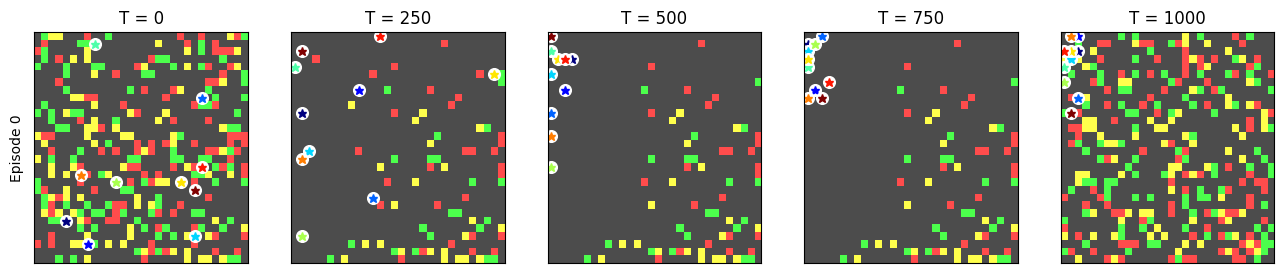

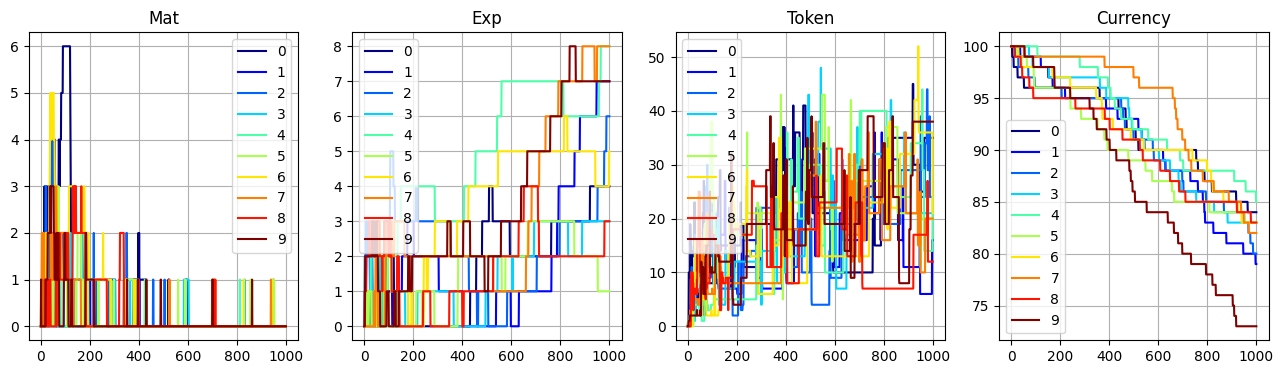

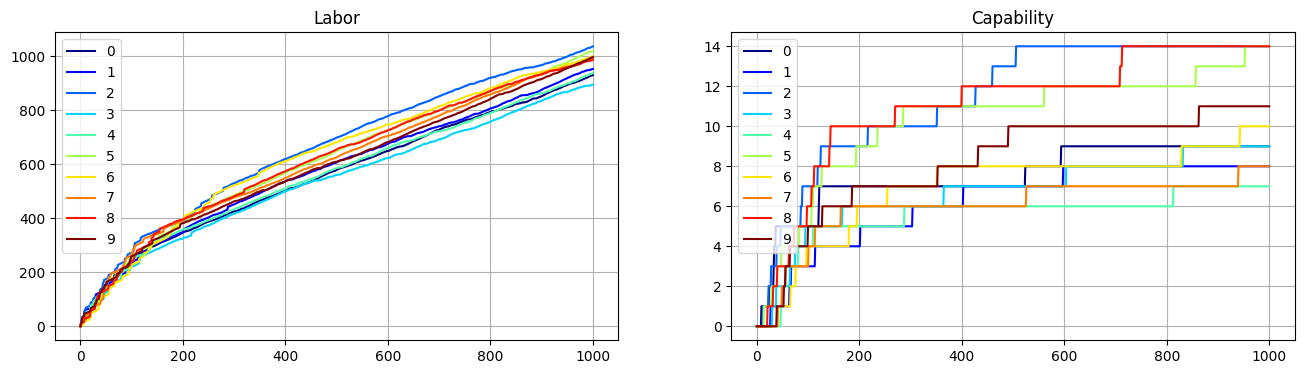

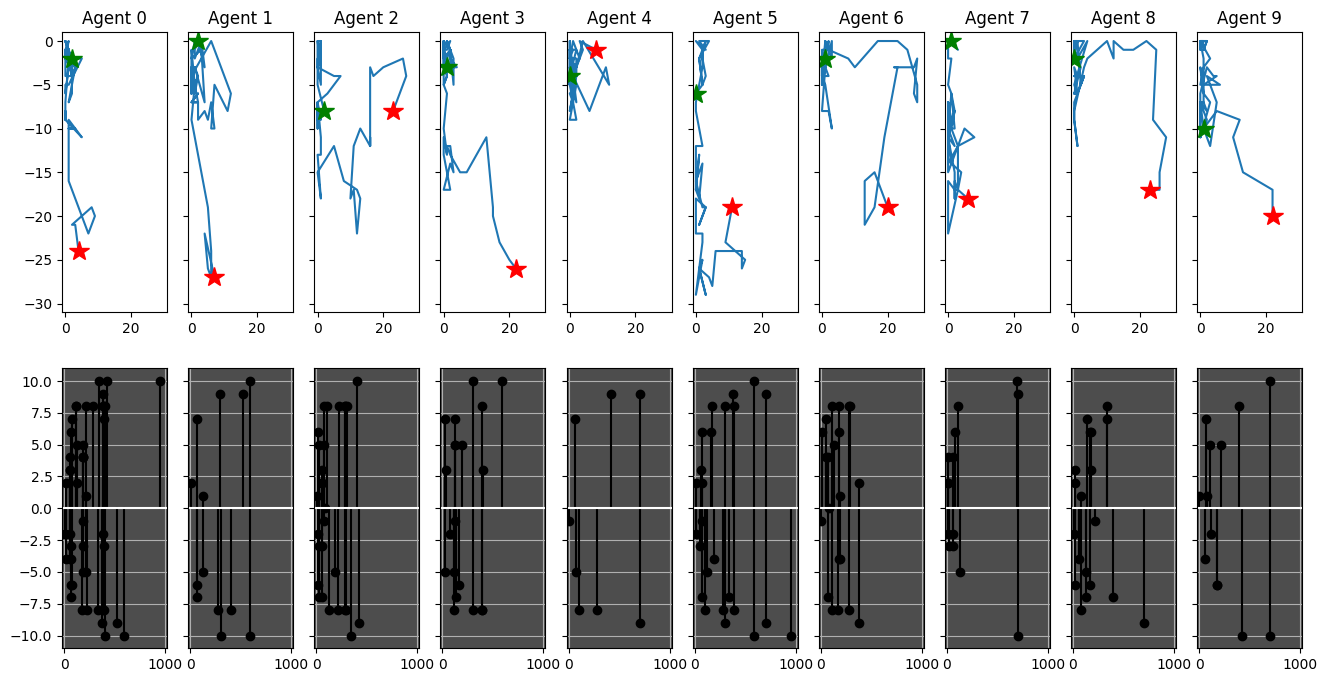

In [6]:
dense_logs = generate_rollout_from_current_trainer_policy(
    trainer, dummy_env, num_dense_logs=1
)
print(dummy_env.env._player_utility_monetary_cost_sensitivities)
print(dummy_env.env._player_utility_nonmonetary_cost_sensitivities)
plotting.breakdown(dense_logs[0])